In [1]:
import importlib

# from torch.utils.data import DataLoader, random_split
from torch import cuda, nn, optim, concat
from torch.backends import mps

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from numpy import argmax
from sklearn.cluster import KMeans  #, SpectralClustering, HDBSCAN

import datasets.mnist_loader as ml
from ptmodels import vae_pytorch as vp
from plotting import ae_plots

# Use a gpu or M1 chipset to train PyTorch networks if you have it.
if cuda.is_available():
    device = 'cuda'

elif mps.is_available():
    device = 'mps'

else: 
    device = 'cpu'

print(f'Using {device}.')

%matplotlib widget

Using mps.


# Project 2: Autoencoders and Variational Autoencoders.
In this project, we are going to first implement a couple autoencoders trained on MNIST-compatible data sets for dimensionality reduction. Afterwards, we'll then create a generative model using a variational autoencoder. 

## Project 2.1: Autoencoders for Dimensionality Reduction.
High dimensionality data frequently has more dimensions than is needed to perform regression, classification, or clustering.  More formally, there is a lot of covariance within most data, covariance that reduces the intrinsic dimensionality of the data set.  Think of image data --- a $128 \times 128$ pixel image can be thought of as a vector $\mathbf{x}$ which resides in a $416384$-dimensional vector space. That does not mean there are $416384$ unique features.  Intuitively, we know there are less features in the data, and those features are captured by correlations between pixels.  In other words, we could find a mapping from the starting representation $\mathbf{x}$ to a reduced-dimension latent representation $\mathbf{z}\in \mathcal{R}^m$, where hopefully $m \ll 16384$.  We can then use more approachable latent representation $\mathbf{z}\in \mathcal{Z}$ to analyze the starting dataset $\mathbf{x}\in \mathcal{X}$.

An autoencoder does this by finding three things: a latent representation $\mathbf{z}\in \mathcal{Z}$, an encoding function $E_{\phi}(\mathbf{x})=\mathbf{z}$ parameterized by $\phi$, and a decoding function $D_{\theta}(\mathbf{z})=\mathbf{x}$ parameterized by $\theta$. Here, we will simultaneously train two dense, multi-layer perceptrons to estimate functions $E_{\phi}$ and $D_{\theta}$, recovering the latent space $\mathcal{Z}$ in the process. 

Training the perceptron networks requires a loss function.  Although the data we are training on is labeled, we will not be using them.  Instead, we are going to perform unsupervised learning.  Specifically, we'll are going to optimize by minimizing the 'distance' between the starting vector $\mathbf{x}$ and its predicted decoding $D_{\phi}(E_{\theta}(\mathbf{x}))$: 

$L(\mathcal{X}|\phi, \theta)=-\frac{1}{N}\sum^N_{i=1}L_2[\mathbf{x}_i, D_{\phi}(E_{\theta}(\mathbf{x}_i))]$

where $N$ is the size of the training data sample $\mathcal{X}$ and $L_2(\mathbf{x}, \mathbf{x}^{\prime})=|| \mathbf{x} - \mathbf{x}^{\prime} ||^2$ is the L2 loss (basically, the Euclidian distance up to some multiplicative constant). To train, we will minimize $L(\mathcal{X}|\phi, \theta)$ with respect to the parameters $\phi$ and $\theta$.

Enough math.  Let's start setting up the model to train!

In [2]:
importlib.reload(ml)
# Let's load some PyTorch DataLoaders we'll be using using a wrapper function in the 'mnist_loader.py' module.
train_dl, validation_dl = ml.load_MNISTlike(
    target_set='MNIST', batch_size_train=64, batch_size_validation=128
)

torch.Size([28, 28])
tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0])


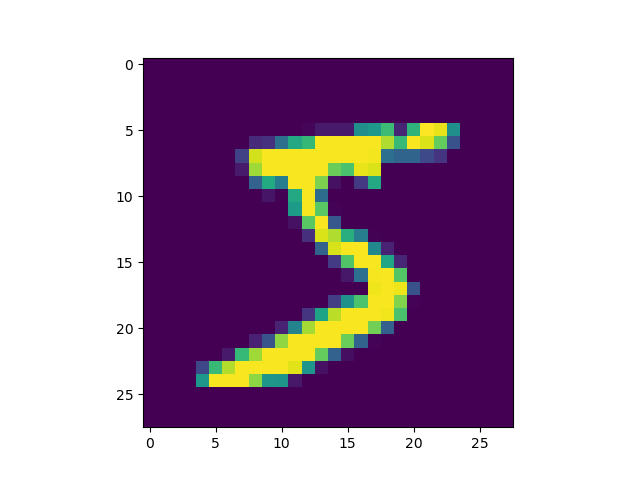

In [3]:
# Let's inspect an image
x, y = train_dl.dataset.__getitem__(0)

print(x[0].shape)  # each image is a single-channel 28 x 28 image.
print(y)  # one-hot encoding correponds to the number 5 label. 
plt.imshow(x.permute(1, 2, 0))
plt.show()

We need a loss function from Pytorch that satisfies the requirements above.  Luckily, `torch.nn.MLELoss` does just that. We'll also use the Adam optimizer.  As for the the model itself, the number of hidden layers will be four, including the final latent layer estimating $\mathcal{Z}$. The starting input dimension is $28 \times 28=784$ and we are going to select a latent space dimension of $3$.

In [29]:
from ptmodels import tracking
importlib.reload(tracking)
importlib.reload(vp)

# Model hyperparameters
n_epochs = 4
lr = 7.5e-3
n_latent = 3

# Instantiate model
img_size = (28, 28)
n_layers = [img_size[0] * img_size[1], 392, 196, 98, 49]
n_channels = 1
ae_model = vp.DenseAE(n_layers, n_latent, img_size, n_channels=n_channels)
ae_model = ae_model.to(device)  # apply model to device.

# Select optimizer.
opt = optim.Adam(ae_model.parameters(), lr=lr)

# Select loss fuction.
loss_fn = nn.MSELoss()

# Print parameter count.
sum([x.numel() for x in ae_model.parameters()])

821148

In [30]:
importlib.reload(vp)
# Train model.
tracker_AE = vp.train_AE(train_dl, validation_dl, ae_model, opt, loss_fn, n_epochs, device)

Batch [   64/60000] loss: 1.290323.
Batch [12864/60000] loss: 0.790114.
Batch [25664/60000] loss: 0.751119.
Batch [38464/60000] loss: 0.745696.
Batch [51264/60000] loss: 0.715322.
Epoch 1 validation loss: 0.699501.
---------------------------------------
Batch [   64/60000] loss: 0.701492.
Batch [12864/60000] loss: 0.664995.
Batch [25664/60000] loss: 0.635379.
Batch [38464/60000] loss: 0.655469.
Batch [51264/60000] loss: 0.648877.
Epoch 2 validation loss: 0.637934.
---------------------------------------
Batch [   64/60000] loss: 0.675072.
Batch [12864/60000] loss: 0.633431.
Batch [25664/60000] loss: 0.617713.
Batch [38464/60000] loss: 0.661269.
Batch [51264/60000] loss: 0.638505.
Epoch 3 validation loss: 0.629013.
---------------------------------------
Batch [   64/60000] loss: 0.620621.
Batch [12864/60000] loss: 0.613307.
Batch [25664/60000] loss: 0.605225.
Batch [38464/60000] loss: 0.606110.
Batch [51264/60000] loss: 0.600489.
Epoch 4 validation loss: 0.614774.
--------------------

torch.Size([1, 28, 28])
tensor([0, 0, 0, 1, 0, 0, 0, 0, 0, 0])


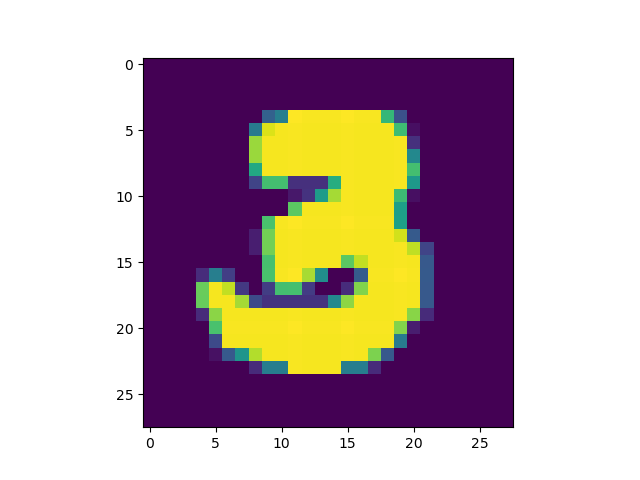

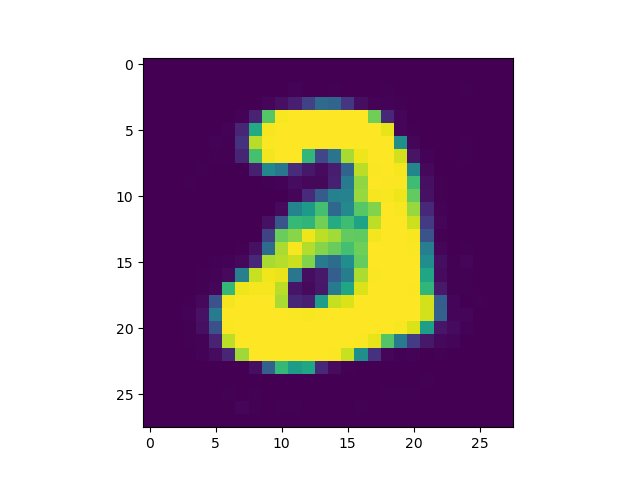

In [31]:
# Alright --- let's see how the model performs.  
# Note that we have to unflatten the prediction, which we do using some torch.nn functionality.
x_test, y_test = validation_dl.dataset.__getitem__(200)
print(x_test.shape)
x_test = x_test.to(device)

# We select the second dimension of the 2D output to unflatten into a 28x28 image.
print(y_test)  # get encoding output. 
plt.figure()
plt.imshow(x_test.to('cpu').permute(1, 2, 0))
plt.show()

# Get prediction.
x_pred = ae_model(x_test.unsqueeze(0))

# Note we call the first and in this case, the only, batch member 0 from x_pred.
# This model outputs a batch prediction, hence why we 'unsqueezed our input above.
plt.figure()
plt.imshow(x_pred[0].detach().to('cpu').permute(1, 2, 0))
plt.show()


This is a pretty neat result.  Let's consider a couple things real quick.  First, this is only a four-layer encoder that maps to the latent space $\mathcal{Z}$.  We could increase the network depth.  Second, this encoding exists in three dimensions: $\mathbf{z}\in \mathcal{R}^3$.  This means we were able to start with $784$-dimension vectors and then find a three-dimensional representation that contains enought information about the training data to recover, via the decoder, the initial image with reasonable accuracy.  

Let's actually make use of this latent representation and run some clustering algorithms on the validation data set's encoded representations.  Before doing so, we'll collect the encoding predictions first, and the plot the bivariate encoding to see what we are working with.

In [ ]:
# Let's loop the validation data set through and get images and labels.
encoding_batches, labels_batches = zip(
    *[(ae_model.get_encoding(xb.to(device)), yb.to(device)) for xb, yb in validation_dl]
)

# Take the tuples of batches and concatenate.  Also, detach the tensors --- no need to track gradients.
encodings = concat(encoding_batches).detach().cpu().numpy()
# normed_encodings = vp.SymmetricLinearAE.normalize_encoding(encodings)
labels = concat(labels_batches).detach().cpu().numpy()


In [ ]:
importlib.reload(ae_plots)
# What does this 3D encoding look like?
encoding_fig = ae_plots.plot_3Dencoding(
    encodings, figsize=(8, 8), marker='.', color='black', alpha=0.2
)
plt.show()

The data exhibits some clearly nonlinear behavior.  Regardless, let's play around with some classification algorithms and see how things look.

In [ ]:
# scikit-learn models must first be instantiated, then fit using the 'fit()' method.  
# Keep in mind that the fitting sample must be fed in as a column vector of features. 
# Because we are fitting clustering algorithms, no labels (aka no independent variable values)
# Need to be provided (specifically, the keyword argument 'y=None' for 'fit()').

# Instantiate and fit a K-Means model with 10 clusters.
km_model = KMeans(init='k-means++', n_clusters=10, n_init=8)
km_model.fit(encodings)

# Instantiate and fit a Spectral Clustering model with 10 clusters. This
# algorithm is slower than k-means but does not assume densities are convex
# or isotropic.
# sc_model = SpectralClustering(n_clusters=10, n_init=8)
# sc_model.fit(encodings)

# Instantiate and fit a HDBSCAN model.  This algorithm is more unsupervised,
# finding the label count from the data.
# hds_model = HDBSCAN(min_cluster_size=200, min_samples=50)
# hds_model.fit(encodings)

# # Instantiate and fit a DBSCAN model.  This algorithm is more unsupervised,
# # finding the label count from the data.
# bw = estimate_bandwidth(encodings, n_samples=500)
# ms_model = MeanShift(bandwidth=bw)
# ms_model.fit(encodings)

In [ ]:
importlib.reload(ae_plots)

# Let's plot the different clustering algorithm results.
km_fig = ae_plots.plot_3Dencodings_withclusters(
    encodings, km_model.labels_,
    'K-Means', 10,
    encoding_kwargs={'color': 'black', 'marker': '.', 'alpha': 0.1},
    clusters_kwargs={'marker': 'o', 'alpha': 0.15}
)
plt.show()


## Project 2.2: ConvNet Autoencoder.

Already we are running into issues discovering clusters in the encoded representation.  The encoded representation is not well-behaved for these clusteringa algorithms, featuring complex density curvature, including visibly varying length scales if we instead had an encoding dimension of two.  All this alone hints that an encoding dimension of two or three may be too low to be immediately useful, even if the decoder can still recover a decent prediction from the latent space representation.  It could very well be that only having two latent features is simply insufficient to describe variation in our training set.  

Recall that we are trying to find a latent representation of image data --- maybe it makes sense to instead build an autoencoder with ConvNet layers. Unfortunately, this is easier said then done.  Convolution (technically cross-correlation for ConvNet applications) does have an inverse operation call a transpose convolution.  We could mirror a ConvNet encoder with a transpose ConvNet decoder.  Unfortunately, this ignores using max pooling, a powerful ConvNet layer, especially for deep networks.  By construction, max pooling has no inverse operation since it is a many-to-one operation.  

For the first ConvNet autoencoder, will use blocks of two convolutions and a single max pooling layer.  After all of these blocks, a single dense linear layer will yield the latent representation. The decoder starts with a single dense layer mapping the encoding space to a square image compatible feature (specifically, this hidden layer must output hidden features of dimension $n_h$ equal to $n_x \times n_y \times n_c$, where $n_x$, $n_y$, and $n_c$ are the image height, width, and channel count, respectively).  Blocks with a single upscaling layer, followed by two convolutions, will eventually output the reconstructed image.

In [ ]:
importlib.reload(vp)

# Model hyperparameters
n_epochs = 4
channels = [1, 4, 8]
k_layers = [5, 3]
n_latent = 3

# Instantiate model.
n_flat = 7 * 7 * 8  # final hidden convnet 'image' size times number of channels.
conv_ae_model = vp.ConvNetAE(channels, k_layers, n_flat, n_latent).to(device)

# Select optimizer.
lr = 7.5e-3
opt = optim.Adam(conv_ae_model.parameters(), lr=lr)

# Select loss fuction.
loss_fn = nn.MSELoss()

# Get parameter count.
sum([x.numel() for x in conv_ae_model.parameters()])

In [ ]:
importlib.reload(vp)
# Train model.
tracker_ConvNetAE = vp.train_AE(train_dl, validation_dl, conv_ae_model, opt, loss_fn, n_epochs, device)

In [ ]:
# Alright --- let's see how the ConvNet model performs.  
x_test, y_test = validation_dl.dataset.__getitem__(200)
x_test = x_test.to(device)

# We select the second dimension of the 2D output to unflatten into a 28x28 image.
print(y_test)  # get encoding output. 
plt.figure()
plt.imshow(x_test.to('cpu').permute(1, 2, 0))
plt.show()

# Get prediction.
x_pred = conv_ae_model(x_test.unsqueeze(0))

# Note we call the first and in this case, the only, batch member 0 from x_pred.
# This model outputs a batch prediction, hence why we 'unsqueezed our input above.
plt.figure()
plt.imshow(x_pred[0].detach().to('cpu').permute(1, 2, 0))
plt.show()


The ConvNet architecture is not performing any better or worse than the dense network, but this is actually pretty is impressive: the ConvNet autoencoder has two orders of magnitude *fewer* free parameters to train than the original dense autoencoder we used.  

MNIST benchmarking, even for large model training, is not particularly demanding --- MNIST images are relatively small and have only one channel. As a result, we aren't immediately seeing the efficiency gained going from a dense linear architecture to a ConvNet architecture.  But I can guarantee that if we were instead trying to encode/decode higher resolution images, the performance and memory load would definitely be noticeably different!

In [ ]:
# Let's loop the validation data set through and get encodings and labels.
c_encoding_batches, c_labels_batches = zip(
    *[(conv_ae_model.get_encoding(xb.to(device)), yb.to(device)) for xb, yb in validation_dl]
)

# Take the tuples of batches and concatenate.  Also, detach the tensors --- no need to track gradients.
c_encodings = concat(c_encoding_batches).detach().cpu().numpy()
c_labels = concat(c_labels_batches).detach().cpu().numpy()


In [ ]:
# Instantiate and fit a K-Means model with 10 clusters.
c_km_model = KMeans(init='k-means++', n_clusters=10, n_init=8)
c_km_model.fit(c_encodings)

# Instantiate and fit a Spectral Clustering model with 10 clusters. This
# algorithm is slower than k-means but does not assume densities are convex
# or isotropic.
# c_sc_model = SpectralClustering(n_clusters=10, n_init=8)
# c_sc_model.fit(c_encodings)

# Instantiate and fit a HDBSCAN model.  This algorithm is more unsupervised,
# finding the label count from the data.
# c_hds_model = HDBSCAN(min_cluster_size=200, min_samples=50)
# c_hds_model.fit(encodings)

In [ ]:
importlib.reload(ae_plots)

# Let's plot the different clustering algorithm results for the ConvNet AE.
c_km_fig = ae_plots.plot_3Dencodings_withclusters(
    c_encodings, c_km_model.labels_,
    'K-Means', 10,
    encoding_kwargs={'color': 'black', 'marker': '.', 'alpha': 0.1},
    clusters_kwargs={'marker': 'o', 'alpha': 0.15}
)
plt.show()

It is not readily apparent which autoencoder is performing better or worse, although the ConvNet architecture seems to have slightly more distnquishable cluters.  Moreover, the point densities exhibit lesss curvature.  Regardless, we need to compare the data labels against the clustering predicted labels to see how the unsupervised classification is performing.

Let's do this with a matching matrix.  Specifically, we will take the ordered labels from the data (1, 2, 3, etc.) and get a vector of predicted 'unordered' labels output from the clustering algorithm of choice.  Luckily, scikit-learn already has an implementation.  We'll focus on the k-means clustering results for now.

In [ ]:
importlib.reload(ae_plots)

# First, convert from one-hot encoding.
labels_inv_one_hot = argmax(labels, axis=1)

km_cmatrix, km_cmatrix_fig = ae_plots.matching_matrix_heatmap(
    'Dense AE K-means',
    labels_inv_one_hot,
    km_model.labels_
)
plt.show()

In [ ]:
# First, convert from one-hot encoding.
c_labels_inv_one_hot = argmax(c_labels, axis=1)

c_km_cmatrix, c_km_cmatrix_fig = ae_plots.matching_matrix_heatmap(
    'ConvNet AE K-means',
    c_labels_inv_one_hot,
    c_km_model.labels_
)
plt.show()

These are interesting results.  At present, neither model performs well enough to be considered a successful implementation, but both seem to be discovering emergent features from the data set.  Again, keep in mind the ConvNet architeture is doing this with 100 times *less* parameters!

Sticking with the ConvNet autoencoder, let's next triple the latent space dimension to nine, which is still far smaller than the starting input dimension of $784$.  We can't readily visualize a six-dimensional scatterplot, but the matching matrix is still readily usable and frankly, more useful.

In [ ]:
importlib.reload(vp)

# Model hyperparameters
n_epochs = 4
channels = [1, 4, 8]
k_layers = [5, 3]
n_latent = 10

# Instantiate model.
n_flat = 7 * 7 * 8  # final hidden convnet 'image' size times number of channels.
conv2_ae_model = vp.ConvNetAE(channels, k_layers, n_flat, n_latent).to(device)

# Select optimizer.
lr = 7.5e-3
opt = optim.Adam(conv2_ae_model.parameters(), lr=lr)

# Select loss fuction.
loss_fn = nn.MSELoss()

# Get parameter count.
sum([x.numel() for x in conv2_ae_model.parameters()])

In [ ]:
tracker_ConvNetAE2 = vp.train_AE(train_dl, validation_dl, conv2_ae_model, opt, loss_fn, n_epochs, device)

c2_encoding_batches, c2_labels_batches = zip(
    *[(conv2_ae_model.get_encoding(xb.to(device)), yb.to(device)) for xb, yb in validation_dl]
)
c2_encodings = concat(c2_encoding_batches).detach().cpu().numpy()
c2_labels = concat(c2_labels_batches).detach().cpu().numpy()


In [ ]:
# Alright --- let's see how the ConvNet model performs.  
x_test, y_test = validation_dl.dataset.__getitem__(200)
x_test = x_test.to(device)

# We select the second dimension of the 2D output to unflatten into a 28x28 image.
print(y_test)  # get encoding output. 
plt.figure()
plt.imshow(x_test.to('cpu').permute(1, 2, 0))
plt.show()

# Get prediction.
x_pred = conv2_ae_model(x_test.unsqueeze(0))

# Note we call the first and in this case, the only, batch member 0 from x_pred.
# This model outputs a batch prediction, hence why we 'unsqueezed our input above.
plt.figure()
plt.imshow(x_pred[0].detach().to('cpu').permute(1, 2, 0))
plt.show()

In [ ]:
c2_km_model = KMeans(init='k-means++', n_clusters=10, n_init=8)
c2_km_model.fit(c2_encodings)

c2_labels_inv_one_hot = argmax(c2_labels, axis=1)

c2_km_cmatrix, c2_km_cmatrix_fig = ae_plots.matching_matrix_heatmap(
    'ConvNet AE K-means',
    c2_labels_inv_one_hot,
    c2_km_model.labels_
)
plt.show()